In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K

In [5]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/CFL_training_data/CFL_training_data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
input_images = []
output_images = []
for image in os.listdir(os.path.join(data_path, 'input'))[:1000]:
  input_images.append(cv2.resize(cv2.imread(os.path.join(data_path, 'input', image)), (256,256)))
  output_images.append(cv2.resize(cv2.imread(os.path.join(data_path, 'output_core', image), cv2.IMREAD_GRAYSCALE), (256,256))/255)
output_images = [image[..., np.newaxis] for image in output_images]

# Model 1 without Skip

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Concatenate, Add

def conv_block(x, filters, kernel_size=(3, 3), padding='same', strides=1):
    x = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def residual_block(x, filters, kernel_size=(3, 3), padding='same', strides=1):
    y = conv_block(x, filters, kernel_size, padding, strides)
    y = conv_block(y, filters, kernel_size, padding, 1)
    if x.shape[-1] != filters:
        x = Conv2D(filters, (1, 1), padding='same', strides=strides)(x)
    return Add()([x, y])

def build_resunet(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(input_shape)

    # Encoder
    conv1 = residual_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = residual_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = residual_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Center
    conv4 = residual_block(pool3, 512)

    # Decoder
    up5 = Concatenate()([UpSampling2D(size=(2, 2))(conv4), conv3])
    conv5 = residual_block(up5, 256)

    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv2])
    conv6 = residual_block(up6, 128)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv1])
    conv7 = residual_block(up7, 64)

    # Output
    output = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage
model = build_resunet()
model.summary()


# Model 2 with Skip

In [7]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Concatenate, Add

def conv_block(x, filters, kernel_size=(3, 3), padding='same', strides=1):
    x = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def residual_block(x, filters, kernel_size=(3, 3), padding='same', strides=1):
    y = conv_block(x, filters, kernel_size, padding, strides)
    y = conv_block(y, filters, kernel_size, padding, 1)
    if x.shape[-1] != filters:
        x = Conv2D(filters, (1, 1), padding='same', strides=strides)(x)
    return Add()([x, y])

def build_resunet(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(input_shape)

    # Encoder
    conv1 = residual_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = residual_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = residual_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Center
    conv4 = residual_block(pool3, 512)

    # Decoder with skip connections
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Concatenate()([up5, conv3])
    conv5 = residual_block(up5, 256)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Concatenate()([up6, conv2])
    conv6 = residual_block(up6, 128)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Concatenate()([up7, conv1])
    conv7 = residual_block(up7, 64)

    # Output
    output = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage
model = build_resunet()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0

# Loss Metrics

In [8]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    """combine DICE and BCE"""
    return 0.01*tf.keras.losses.binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

# Model Compile and Train

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.binary_crossentropy, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [10]:
checkpoint_filepath = os.path.join(data_path, "{epoch:02d}-{val_loss:.2f}.hdf5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [29]:
model.fit(x=np.array(input_images),
    y=np.array(output_images),
    validation_split=0.2,
    batch_size=8,
    epochs=30,
    callbacks=[model_checkpoint_callback],
    shuffle=False)

Epoch 1/30
100/100 [==============================] - 55s 241ms/step - loss: 0.1871 - dice_coef: 0.7598 - binary_accuracy: 0.9210 - true_positive_rate: 0.9029 - val_loss: 0.4880 - val_dice_coef: 0.1639 - val_binary_accuracy: 0.8267 - val_true_positive_rate: 0.0094
Epoch 2/30
100/100 [==============================] - 23s 230ms/step - loss: 0.0934 - dice_coef: 0.8407 - binary_accuracy: 0.9404 - true_positive_rate: 0.9137 - val_loss: 0.3101 - val_dice_coef: 0.4599 - val_binary_accuracy: 0.8627 - val_true_positive_rate: 0.2602
Epoch 3/30
100/100 [==============================] - 23s 230ms/step - loss: 0.0797 - dice_coef: 0.8611 - binary_accuracy: 0.9437 - true_positive_rate: 0.9233 - val_loss: 0.1258 - val_dice_coef: 0.7745 - val_binary_accuracy: 0.9305 - val_true_positive_rate: 0.7322
Epoch 4/30
100/100 [==============================] - 23s 230ms/step - loss: 0.0707 - dice_coef: 0.8739 - binary_accuracy: 0.9461 - true_positive_rate: 0.9292 - val_loss: 0.0736 - val_dice_coef: 0.8644 - v

# Architecture 3

In [24]:
def bn_act(x, act=True):
    x = tf.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tf.keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)

    shortcut = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = tf.keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding='same', strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)

    shortcut = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = tf.keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = tf.keras.layers.UpSampling2D((2, 2))(x)
    c = tf.keras.layers.Concatenate()([u, xskip])
    return c

In [26]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = tf.keras.layers.Input((256, 256, 3))

    ## ENCODER
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)

    # BRIDGE
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)

    # DECODER
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])

    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])

    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])

    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])

    outputs = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(d4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

In [27]:
model = ResUNet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_22 (Conv2D)          (None, 256, 256, 16)         448       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_14 (Ba  (None, 256, 256, 16)         64        ['conv2d_22[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_14 (Activation)  (None, 256, 256, 16)         0         ['batch_normalization_14

# Model Saving and Prediction

In [30]:
model.save(os.path.join(data_path, 'final_resunet_3rd_model_30_ep.hdf5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
pred = model.predict(np.array(input_images[:5]))

1/1 [==============================] - 4s 4s/step


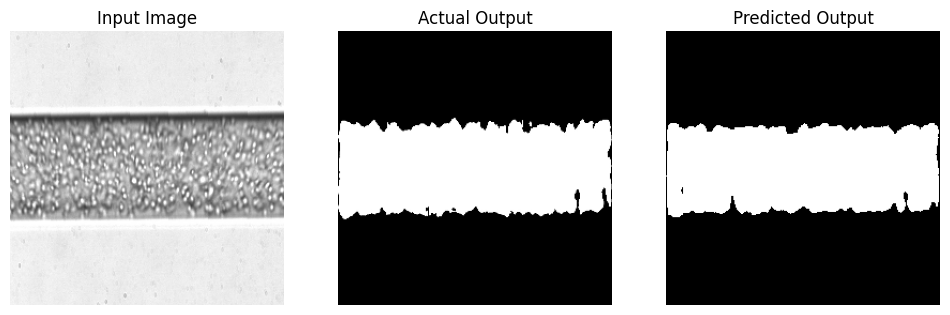

In [40]:
plt.figure(figsize=(12, 4))

# Display Input Image
plt.subplot(1, 3, 1)
plt.imshow(input_images[0])
plt.title('Input Image')
plt.axis('off')

# Display Actual Output (Ground Truth)
plt.subplot(1, 3, 2)
plt.imshow(output_images[0], cmap='gray')  # Adjust the colormap based on your task
plt.title('Actual Output')
plt.axis('off')

# Display Predicted Output
plt.subplot(1, 3, 3)
plt.imshow(pred[0]>0.5, cmap='gray')  # Adjust the colormap based on your task
plt.title('Predicted Output')
plt.axis('off')

plt.show()